In [1]:
# from drive
!unzip ./drive/MyDrive/single-person-pose-estimation/dataset/tfrecords.zip

Archive:  ./drive/MyDrive/single-person-pose-estimation/dataset/tfrecords.zip
   creating: dataset/tfrecords/
   creating: dataset/tfrecords/train/
  inflating: dataset/tfrecords/train/file_train_42-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_24-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_58-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_03-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_48-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_32-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_64-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_45-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_18-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_11-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_40-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_16-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_50-2048.tfrec  
  inflating: dataset

* Import modules

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import sys
sys.path.append('/content/drive/MyDrive/single-person-pose-estimation')

In [4]:
from configs import default_config as cfg
from model.hourglass import create_hourglass_model
from dataset_builder import DatasetBuilder
from utilities.model_utils import compile_model_from_checkpoint

* Model

In [5]:
model = create_hourglass_model(cfg.NUM_KEYPOINTS, 
                                 cfg.HG_NUM_STACKS,
                                 cfg.HG_NUM_CHANNELS,
                                 cfg.IMAGE_SHAPE,
                                 cfg.HM_ACTIVATION) # for better result should match the act it was trained on

Created Hourglass model:
    1. 2 stacks.
    2. 7034530 parameters. Call model.get_summary() for more detail.
    


In [6]:
model = compile_model_from_checkpoint(model, '/content/drive/MyDrive/single-person-pose-estimation/temp/checkpoints/best_val_loss_weights.ckpt',
                                 optimizer = tf.keras.optimizers.Adam(),
                                 loss = tf.keras.losses.MeanSquaredError())

* Dataset

In [7]:
ds_builder = DatasetBuilder(cfg)

Train dataset with 66 tfrecords and 134214 examples.
Valid dataset with 3 tfrecords and 5647 examples.


In [8]:
ds = ds_builder.get_ds_prediction()

In [9]:
it = iter(ds)

In [10]:
imgs_batch, meta = next(it)

* Predict whole dataset

In [11]:
def heatmaps_to_keypoints_v1(heatmaps, conf_threshold = 1e-6):
  ''' Work for one batch
  :param heatmaps: shape(64, 64, number of keypoints)
  :return np.array
  '''
  keypoints = np.zeros(shape=(17, 3), dtype=np.float32)
  for i in range(17):
    heatmap = heatmaps[:,:,i]
    index = np.argmax(heatmap) # return index when flattened
    x = index%64
    y = index//64
    conf = heatmap[y, x]
    if conf > conf_threshold:
      keypoints[i, 0] = x
      keypoints[i, 1] = y
      keypoints[i, 2] = conf
    else:
      keypoints[i, 0] = 0
      keypoints[i, 1] = 0
      keypoints[i, 2] = 0
  return keypoints

In [12]:
def heatmaps_to_keypoints_v2(heatmaps, conf_threshold = 1e-6):
  ''' Work for one batch
  :param heatmaps: shape(64, 64, number of keypoints)
  :return np.array
  '''
  keypoints = np.zeros(shape=(17, 3), dtype=np.float32)
  for i in range(17):
    heatmap = heatmaps[:,:,i]
    index = np.argmax(heatmap) # return index when flattened
    x = index%64
    y = index//64
    conf = heatmap[y, x]

    # patch
    x1 = max(x-1, 0)
    x2 = min(x+2, 64)
    y1 = max(y-1, 0)
    y2 = min(y+2, 64)
    patch = heatmap[y1:y2, x1:x2]
    patch[1][1] = 0
    patch_index = np.argmax(patch)
    patch_x = patch_index%3
    patch_y = patch_index//3

    delta_x = patch_x/4
    delta_y = patch_y/4


    if conf > conf_threshold:
      keypoints[i, 0] = x + delta_x
      keypoints[i, 1] = y + delta_y
      keypoints[i, 2] = conf
    else:
      keypoints[i, 0] = 0
      keypoints[i, 1] = 0
      keypoints[i, 2] = 0
  return keypoints

In [13]:
def create_oks_obj(ann_id, image_id, pred_kpts, score):
  oks_obj = {}
  oks_obj['image_id'] = image_id
  oks_obj['ann_id'] = ann_id
  oks_obj['category_id'] = 1
  oks_obj['keypoints'] = pred_kpts
  oks_obj['score'] = score
  return oks_obj

In [14]:
def gen_predictions_list(model, ds, ds_length, batch_size, heatmaps_to_keypoints_func):
  num_iterations = int(np.ceil(ds_length/batch_size))
  it = iter(ds)
  list_of_prediction = []
  image_ids = []
  for i in range(num_iterations):
    images_batch, meta = next(it)
    pred = model.predict(images_batch)
    # need index j since meta is a dict that each item contains (batch_size) tensors
    for j, p in enumerate(pred[-1]): # only last output of the model
      # Each p is an example/instance

      # Get keypoints and undo them into original shape
      keypoints = heatmaps_to_keypoints_func(p, conf_threshold = 0.01)
      original_width = int(meta['original_width'][j])
      original_height = int(meta['original_height'][j])
      bbox_x = float(meta['bbox_x'][j])
      bbox_y = float(meta['bbox_y'][j])
      offset_width = float(meta['offset_width'][j])
      offset_height = float(meta['offset_height'][j])
      x_coords = keypoints[:, 0] * (original_width/64) + (bbox_x - offset_width)
      y_coords = keypoints[:, 1] * (original_height/64) + (bbox_y - offset_height)

      coco_kpts = []
      for x, y in zip(x_coords, y_coords):
        coco_kpts.append(int(x))
        coco_kpts.append(int(y))
        coco_kpts.append(1) # visible flag should be 1
    
        
      # Get score
      score = float(np.mean(keypoints[:, 2])) # need to convert to python float

      # Get other meta data for oks objt
      ann_id = int(meta['ann_id'][j])
      image_id = int(meta['image_id'][j])
      
      # oks object
      oks = create_oks_obj(ann_id, image_id, coco_kpts, score)
      list_of_prediction.append(oks)

      image_ids.append(image_id)
      
  return list_of_prediction, image_ids

In [15]:
list_of_prediction, image_ids = gen_predictions_list(model, ds, ds_builder.num_valid_examples, 16, heatmaps_to_keypoints_v2)

In [16]:
print(len(list_of_prediction))
print(ds_builder.num_valid_examples)

5647
5647


In [17]:
list_of_prediction[0]

{'ann_id': 230831,
 'category_id': 1,
 'image_id': 139,
 'keypoints': [426,
  172,
  1,
  428,
  168,
  1,
  428,
  168,
  1,
  433,
  165,
  1,
  440,
  165,
  1,
  439,
  176,
  1,
  441,
  175,
  1,
  437,
  192,
  1,
  431,
  203,
  1,
  417,
  213,
  1,
  420,
  213,
  1,
  445,
  222,
  1,
  453,
  222,
  1,
  439,
  258,
  1,
  450,
  255,
  1,
  440,
  296,
  1,
  461,
  288,
  1],
 'score': 0.21877139806747437}

In [18]:
from urllib.request import urlopen
import json

In [19]:
with open("result_v1.json", "w") as outfile:
    json.dump(list_of_prediction, outfile)

In [20]:
kpts = list_of_prediction[0]['keypoints']
x = [kpts[i] for i in range(len(kpts)) if i%3 == 0]
y = [kpts[i] for i in range(len(kpts)) if i%3 == 1]

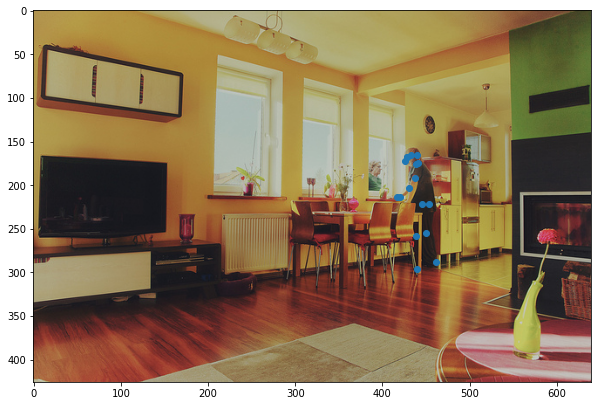

In [21]:
f = urlopen("http://images.cocodataset.org/val2017/000000000139.jpg")
a = plt.imread(f, format = 'jpeg')
plt.figure(figsize =(10,10))
plt.imshow(a)
plt.scatter(x , y , marker = "o") # for heatmap size
plt.show()

In [22]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [23]:
cocoGt= COCO('/content/drive/MyDrive/single-person-pose-estimation/dataset/annotations/person_keypoints_val2017.json')

loading annotations into memory...
Done (t=1.56s)
creating index...
index created!


In [24]:
cocoDt = cocoGt.loadRes('result_v1.json')

Loading and preparing results...
DONE (t=0.26s)
creating index...
index created!


In [25]:
annType = "keypoints"
cocoEval = COCOeval(cocoGt,cocoDt,annType)
cocoEval.params.imgIds = image_ids
cocoEval.params.catIds = [1] # Person category
cocoEval.evaluate()
cocoEval.accumulate()
print('\nSummary: ')
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=4.94s).
Accumulating evaluation results...
DONE (t=0.08s).

Summary: 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.471
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.771
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.509
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.434
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.530
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.511
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.788
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.552
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.456
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.590


In [ ]:
stats = cocoEval.stats
stats

array([0.52971025, 0.80727985, 0.59813638, 0.49027946, 0.59077209,
       0.57710863, 0.82645297, 0.6448114 , 0.52320442, 0.65666797])



---



---

Epoch 15


weighed loss new :array([0.06965629, 0.34622811, 0.0021914 , 0.06690964, 0.07905826,
       0.11324267, 0.42949652, 0.02509309, 0.09712707, 0.13629253])

weghted loss old: array([0.13640148, 0.569036  , 0.0102038 , 0.13194829, 0.14870684,
       0.20212077, 0.63752631, 0.07430792, 0.17911602, 0.23523661])



---


Demo

In [ ]:
image = tf.io.decode_image(tf.io.read_file("person_1.jpg"), channels=3, dtype=tf.dtypes.float32)
image = tf.image.resize(image, (256, 256))
image = tf.expand_dims(image, axis = 0)
image.shape

TensorShape([1, 256, 256, 3])

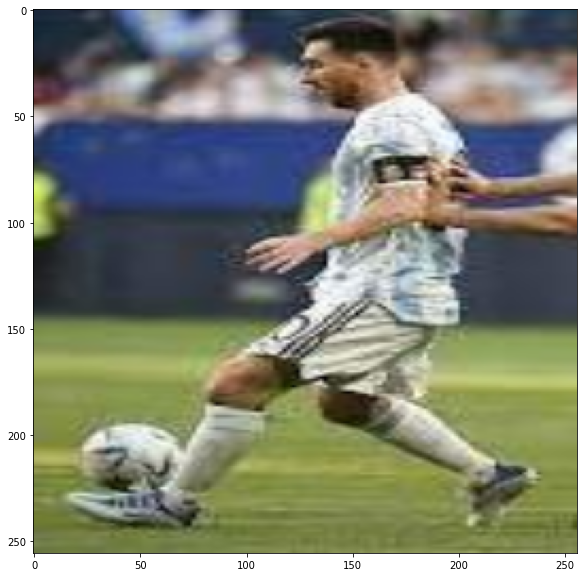

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image[0])

In [ ]:
pred = model.predict(image)

In [ ]:
keypoints = heatmaps_to_keypoints_v2(pred[-1][0], conf_threshold = 0.01)
print(keypoints)

[[31.25        7.5         0.7911382 ]
 [33.          6.25        0.8629543 ]
 [31.5         6.25        0.91088325]
 [38.25        6.          0.9556572 ]
 [40.25        5.5         0.23982546]
 [40.5        13.25        0.52484465]
 [38.         13.25        0.37543833]
 [44.         22.25        0.61235774]
 [37.         24.25        0.55264544]
 [33.         26.25        0.73256683]
 [32.25       27.          0.65041673]
 [41.5        34.25        0.60331994]
 [36.5        32.25        0.53063124]
 [23.5        43.25        0.7868799 ]
 [36.25       45.5         0.63684976]
 [16.25       57.          0.6638193 ]
 [52.5        54.25        0.8452902 ]]


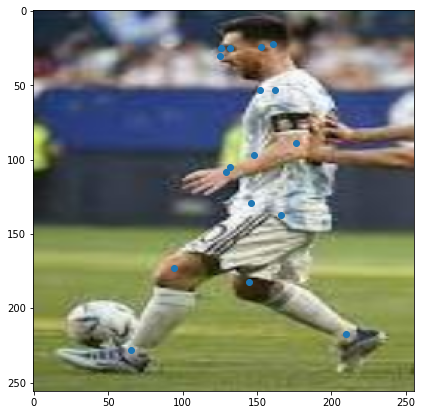

In [ ]:
plt.figure(figsize = (7,7))
plt.imshow(image[0])
plt.scatter(keypoints[:,0] *(256/64), keypoints[:, 1] * (256/64))